In [25]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [26]:
import math
import os
import time


import numpy as np
np.set_printoptions(legacy='1.25')

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product
import copy


from tqdm import tqdm

from scipy.stats import pearsonr
from importlib import reload

import orjson
import gzip

from scipy.stats import entropy



from lib import sketches, visualization_utils, encoders, ploting, pacha_sketch
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)

reload(pacha_sketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily,\
      CountMinSketchHadamard, CountMinSketchLocalHashing, deterministic_hash, simple_deterministic_hash, \
      fast_hash_xx
from lib.visualization_utils import visualize_badic_cover, plot_b_adic_cubes
from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover, BAdicCube, BAdicRange, \
      minimal_b_adic_cover_array, downgrade_b_adic_range_indices
from lib.pacha_sketch import PachaSketch, ADTree, BFParameters, CMParameters, \
      cartesian_product, get_n_updates

from lib.ploting import set_style, plot_ylabel, plot_legend

from lib import baselines
reload(baselines)

from lib.baselines import CentralDPServer, LDPServer, LDPEncoderGRR, filter_df, query_df, \
      infer_domains_and_ranges, translate_query_region, evaluate_queries, check_accruracy, \
      evaluate_queries_baselines, evaluate_equivalent_pacha_sketches

# set_style()

# Different Datasets

In [4]:
delta = 0.01
abs_error_eps = 1.0
bloom_p = 0.01
levels = 6

## Retail

In [5]:
n_cat = 3
n_num = 3

cat_updates, num_updates, region_updates = get_n_updates(n_cat, n_num, levels)

In [6]:
retail_df = pd.read_parquet("../data/clean/online_retail_no_outliers.parquet")
query_path = "../queries/online_retail_2_cols.json"
with open(query_path, 'rb') as f:
    retail_queries_2 = orjson.loads(f.read())

query_path = "../queries/online_retail_4_cols.json"
with open(query_path, 'rb') as f:
    retail_queries_4 = orjson.loads(f.read())

retail_ad_tree = ADTree.from_json("../sketches/ad_trees/online_retail.json")


In [167]:
def peek_sizes(df_len, cat_updates, num_updates, region_updates):   
    df_len = len(retail_df)
    delta = 0.01
    levels = 6

    probs = 2**np.arange(7)*0.005
    rel_epsilons = 2**np.arange(7) * 0.00025

    for p, rel_eps in zip(probs, rel_epsilons):
        error_eps = rel_eps /(region_updates)
        size = 0
        cat_m, k = BFParameters(n_values=df_len*cat_updates, p=p).peek_size()
        print(f"p: {p}, k: {k}, eps: {error_eps}, rel_eps: {rel_eps}")
        size_cat = cat_m/8/1024/1024
        print(f"Size for categorical index: {size_cat:.2f} MB")
        size += size_cat
        num_m, k = BFParameters(n_values=df_len * num_updates, p=p).peek_size()
        size_num = num_m/8/1024/1024
        print(f"Size for numerical index: {size_num:.2f} MB")
        size += size_num
        region_m, k = BFParameters(n_values=df_len * region_updates, p=p).peek_size()
        size_region = region_m/8/1024/1024
        print(f"Size for region index: {size_region:.2f} MB")
        size += size_region

        w,d = CMParameters(delta=delta, error_eps=error_eps).peek_size()
        size_cm = w * d * 4 / 1024 / 1024
        print(f"Size for Count-Min Sketch: {size_cm:.2f} MB")
        size += (size_cm * levels)
        print("---------------------------")
        print(f"Total size: {size:.2f} MB\n")


In [165]:
peek_sizes(len(retail_df), cat_updates_retail, num_updates_retail, region_updates_retail)

p: 0.005, k: 8, eps: 1.3020833333333333e-06, rel_eps: 0.00025
Size for categorical index: 2.82 MB
Size for numerical index: 33.85 MB
Size for region index: 135.41 MB
Size for Count-Min Sketch: 39.82 MB
---------------------------
Total size: 411.00 MB

p: 0.01, k: 7, eps: 2.6041666666666666e-06, rel_eps: 0.0005
Size for categorical index: 2.45 MB
Size for numerical index: 29.42 MB
Size for region index: 117.70 MB
Size for Count-Min Sketch: 19.91 MB
---------------------------
Total size: 269.03 MB

p: 0.02, k: 6, eps: 5.208333333333333e-06, rel_eps: 0.001
Size for categorical index: 2.08 MB
Size for numerical index: 25.00 MB
Size for region index: 99.98 MB
Size for Count-Min Sketch: 9.95 MB
---------------------------
Total size: 186.79 MB

p: 0.04, k: 5, eps: 1.0416666666666666e-05, rel_eps: 0.002
Size for categorical index: 1.71 MB
Size for numerical index: 20.57 MB
Size for region index: 82.27 MB
Size for Count-Min Sketch: 4.98 MB
---------------------------
Total size: 134.41 MB

p

In [166]:
bank_df = pd.read_parquet("../data/clean/bank_marketing.parquet")
peek_sizes(len(bank_df), cat_updates_bank, num_updates_bank, region_updates_bank)

p: 0.005, k: 8, eps: 4.96031746031746e-07, rel_eps: 0.00025
Size for categorical index: 4.94 MB
Size for numerical index: 50.78 MB
Size for region index: 355.46 MB
Size for Count-Min Sketch: 104.52 MB
---------------------------
Total size: 1038.32 MB

p: 0.01, k: 7, eps: 9.92063492063492e-07, rel_eps: 0.0005
Size for categorical index: 4.29 MB
Size for numerical index: 44.14 MB
Size for region index: 308.96 MB
Size for Count-Min Sketch: 52.26 MB
---------------------------
Total size: 670.96 MB

p: 0.02, k: 6, eps: 1.984126984126984e-06, rel_eps: 0.001
Size for categorical index: 3.65 MB
Size for numerical index: 37.49 MB
Size for region index: 262.46 MB
Size for Count-Min Sketch: 26.13 MB
---------------------------
Total size: 460.38 MB

p: 0.04, k: 5, eps: 3.968253968253968e-06, rel_eps: 0.002
Size for categorical index: 3.00 MB
Size for numerical index: 30.85 MB
Size for region index: 215.95 MB
Size for Count-Min Sketch: 13.07 MB
---------------------------
Total size: 328.20 MB



In [157]:
census_df = pd.read_parquet("../data/clean/acs_folktables.parquet")
peek_sizes(len(census_df), cat_updates_census, num_updates_census, region_updates_census)

p: 0.01, k: 7, eps: 1.3020833333333335e-06, rel_eps: 0.0005
Size for categorical index: 4.90 MB
Size for numerical index: 29.42 MB
Size for region index: 235.40 MB
Size for Count-Min Sketch: 39.82 MB
---------------------------
Total size: 508.64 MB

p: 0.02, k: 6, eps: 2.604166666666667e-06, rel_eps: 0.001
Size for categorical index: 4.17 MB
Size for numerical index: 25.00 MB
Size for region index: 199.97 MB
Size for Count-Min Sketch: 19.91 MB
---------------------------
Total size: 348.58 MB

p: 0.04, k: 5, eps: 5.208333333333334e-06, rel_eps: 0.002
Size for categorical index: 3.43 MB
Size for numerical index: 20.57 MB
Size for region index: 164.54 MB
Size for Count-Min Sketch: 9.95 MB
---------------------------
Total size: 248.26 MB

p: 0.08, k: 4, eps: 1.0416666666666668e-05, rel_eps: 0.004
Size for categorical index: 2.69 MB
Size for numerical index: 16.14 MB
Size for region index: 129.10 MB
Size for Count-Min Sketch: 4.98 MB
---------------------------
Total size: 177.80 MB

p: 

In [34]:
def build_pacha_sketch_for_retail(delta=0.01, rel_eps=0.0005, bloom_p=0.01, levels=6):
    """
    Builds a PachaSketch for the retail dataset with specified parameters.
    """
    # Retail
    cat_col_map_retail = [0, 1, 2]
    num_col_map_retail = [3, 4, 5]
    bases_retail = [2, 2, 2]

    n_cat_retail = len(cat_col_map_retail)
    n_num_retail = len(num_col_map_retail)
    cat_updates_retail, num_updates_retail, region_updates_retail = get_n_updates(n_cat_retail, n_num_retail, levels)

    retail_df = pd.read_parquet("../data/clean/online_retail.parquet")
    retail_ad_tree = ADTree.from_json("../sketches/ad_trees/online_retail.json")
    error_eps = rel_eps / region_updates_retail
    retail_p_sketch = PachaSketch.build_with_uniform_size(
        levels=levels,
        num_dimensions=n_cat_retail + n_num_retail,
        cat_col_map=cat_col_map_retail,
        num_col_map=num_col_map_retail,
        bases=bases_retail,
        ad_tree=retail_ad_tree,
        cm_params=CMParameters(delta=delta, error_eps=error_eps),
        cat_index_parameters=BFParameters(n_values=len(retail_df) * cat_updates_retail, p=bloom_p),
        num_index_parameters=BFParameters(n_values=len(retail_df) * num_updates_retail, p=bloom_p),
        region_index_parameters=BFParameters(n_values=len(retail_df) * region_updates_retail, p=bloom_p))

    retail_p_sketch.update_data_frame_multiprocessing(retail_df, workers=8)
    return retail_p_sketch
    # retail_p_sketch.save_to_file(file_path)

In [35]:
retail_p_sketch = build_pacha_sketch_for_retail(delta=delta, rel_eps=0.0005, bloom_p=bloom_p, levels=levels)

/home/rudi/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Building-and-merging: 100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


In [26]:
result_2 = pd.read_csv("../results/accuracy/retail_2_p_sketch.csv")
result_4 = pd.read_csv("../results/accuracy/retail_4_p_sketch.csv")

In [50]:
result_2.columns

Index(['runtimes', 'true_counts', 'estimates', 'relevant_nodes', 'cat_regions',
       'b_adic_cubes', 'num_regions', 'candidate_regions', 'query_regions',
       'level_0_queries', 'level_1_queries', 'level_2_queries',
       'level_3_queries', 'level_4_queries', 'level_5_queries',
       'absolute_error', 'normalized_error', 'relative_error',
       'total_sketch_queries'],
      dtype='object')

In [29]:
(result_2['candidate_regions'] - result_2['query_regions']).describe()

count     200.00000
mean      553.68000
std      1598.94561
min         0.00000
25%         0.00000
50%         0.00000
75%        96.25000
max      8449.00000
dtype: float64

In [ ]:
retail_p_sketch = PachaSketch.build_with_uniform_size(
    levels=6,
    num_dimensions=6,
    cat_col_map=[0,1,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=retail_ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
    cat_index_parameters=BFParameters(n_values=len(retail_df)*4, p=bloom_p),
    num_index_parameters=BFParameters(n_values=len(retail_df)*6, p=bloom_p),
    region_index_parameters= BFParameters(n_values=len(retail_df)*(4+6), p=bloom_p))
retail_p_sketch.get_size(debug=True)

Categorical Index Size: 2.4520530700683594 MB
Numerical Index Size: 3.6780786514282227 MB
Region Index Size: 6.130130767822266 MB
Base Sketches Size: 166.8939971923828 MB
Numerical Bitmaps Size: 0.07152557373046875 MB
--------------------------------------
Total Size: 179.22578525543213 MB


179.22578525543213

In [42]:
abs_error_eps / len(retail_df)

1.8639537441238858e-06

In [47]:
abs_error_eps*region_updates / len(retail_df)

0.0003578791188717861

In [ ]:
len(retail_df)*region_updates

In [31]:
retail_p_sketch = PachaSketch.build_with_uniform_size(
    levels=levels,
    num_dimensions=6,
    cat_col_map=[0,1,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=retail_ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
    cat_index_parameters=BFParameters(n_values=len(retail_df)*cat_updates, p=bloom_p),
    num_index_parameters=BFParameters(n_values=len(retail_df)*num_updates, p=bloom_p),
    region_index_parameters= BFParameters(n_values=len(retail_df)*region_updates, p=bloom_p))
retail_p_sketch.get_size(debug=True)

Categorical Index Size: 2.4520530700683594 MB
Numerical Index Size: 26.359561920166016 MB
Region Index Size: 105.43824768066406 MB
Base Sketches Size: 166.8939971923828 MB
Numerical Bitmaps Size: 0.07152557373046875 MB
--------------------------------------
Total Size: 301.2153854370117 MB


301.2153854370117

In [24]:
retail_df.head(1).to_numpy()

array([['851', 'United Kingdom', 'f', 9, 36, 15]], dtype=object)

In [32]:
retail_p_sketch.update(['851', 'United Kingdom', 'f', 9, 36, 15])

In [33]:
np.sum(retail_p_sketch.base_sketches[0].counters)

140

In [26]:
retail_p_sketch.merge(retail_p_sketch)

In [30]:
np.sum(retail_p_sketch.base_sketches[0].counters)

280

In [29]:
retail_p_sketch.query([['851'], ['United Kingdom'], ['f'], [9,9], [36, 36], [15, 15]])

0

In [116]:
retail_p_sketch.update_data_frame(retail_df)

Updating: 100%|██████████| 536494/536494 [14:22<00:00, 621.73it/s]


In [628]:
retail_p_sketch.save_to_file("../sketches/temp.json.gz")
retail_p_sketch2 = PachaSketch.from_json("../sketches/temp.json.gz")

In [28]:
retail_p_sketch2 = PachaSketch.from_json("../sketches/retail/retail_p0.02_eps0.001.json")

In [9]:
cat_col_map_retail = [0, 1, 2]
num_col_map_retail = [3, 4, 5]
bases_retail = [2, 2, 2]

n_cat_retail = len(cat_col_map_retail)
n_num_retail = len(num_col_map_retail)
cat_updates_retail, num_updates_retail, region_updates_retail = get_n_updates(n_cat_retail, n_num_retail, levels)


In [55]:
len(retail_df)

536494

In [57]:
(len(retail_df) - retail_p_sketch.cat_index.processed_elements / cat_updates_retail) / len(retail_df)

-0.010093309524430842

In [24]:
2**np.arange(2,7)*0.005

array([0.02, 0.04, 0.08, 0.16, 0.32])

In [17]:
retail_p_sketch2.region_index.processed_elements / len(retail_df)

173.7360492382021

In [51]:
retail_p_sketch.base_sketches[0].processed_elements / (region_updates_retail/6)

529306.4651162791

In [22]:
(region_updates_retail-4)/6

28.0

In [21]:
retail_p_sketch2.base_sketches[5].processed_elements / len(retail_df) 

32.32298590478179

In [10]:
retail_p_sketch2.cat_index.processed_elements / cat_updates_retail

541909.0

In [11]:
np.sum(retail_p_sketch2.base_sketches[0].counters, axis=1)

array([15173452, 15173452, 15173452, 15173452, 15173452])

In [46]:
np.sum(retail_p_sketch.base_sketches[0].counters, axis=1)

array([15173452, 15173452, 15173452, 15173452, 15173452])

In [56]:
retail_p_sketch2 = retail_p_sketch

In [36]:
retail_results_2 = evaluate_queries(retail_df, retail_queries_2["queries"], retail_p_sketch)

Computing true counts...


True Count: 100%|██████████| 200/200 [00:06<00:00, 30.39it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:01<00:00, 111.33it/s]


In [18]:
2**np.arange(1,7)*0.005

array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32])

In [16]:
np.sum(retail_p_sketch.region_index.bit_array)

0

In [38]:
retail_results_2_new = pd.read_csv("../results/accuracy/retail_2_p_sketch_new.csv")

In [40]:
retail_results_2_new['absolute_error'].describe()

count    200.000000
mean      47.340000
std       87.882198
min        0.000000
25%        1.000000
50%        2.000000
75%       47.250000
max      498.000000
Name: absolute_error, dtype: float64

In [41]:
retail_results_2['absolute_error'].describe()

count     200.000000
mean      464.415000
std       652.307387
min         0.000000
25%        22.000000
50%        62.500000
75%       977.500000
max      2281.000000
Name: absolute_error, dtype: float64

In [123]:
retail_results_4 = evaluate_queries(retail_df, retail_queries_4["queries"], retail_p_sketch, path_to_file="../results/accuracy/retail_4_p_sketch_new.csv")

Computing true counts...


True Count: 100%|██████████| 200/200 [00:05<00:00, 34.09it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:01<00:00, 101.31it/s]


In [59]:
retail_results_2_old = pd.read_csv("../results/accuracy/retail_2_p_sketch.csv")
retail_results_4_old = pd.read_csv("../results/accuracy/retail_4_p_sketch.csv")

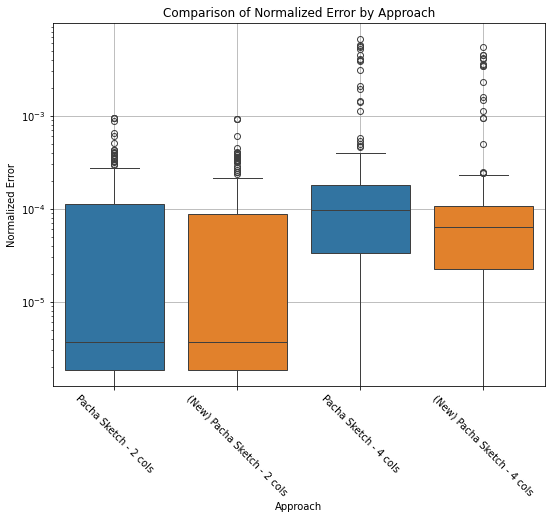

In [124]:
retail_results_2_old['approach'] = 'Pacha Sketch - 2 cols'
retail_results_2['approach'] = '(New) Pacha Sketch - 2 cols'

retail_results_4_old['approach'] = 'Pacha Sketch - 4 cols'
retail_results_4['approach'] = '(New) Pacha Sketch - 4 cols'

custom_palette = {
    'Pacha Sketch - 2 cols': 'tab:blue',
    '(New) Pacha Sketch - 2 cols': 'tab:orange',
    'Pacha Sketch - 4 cols': 'tab:blue',
    '(New) Pacha Sketch - 4 cols': 'tab:orange',
    }

# Combine the DataFrames
combined_df = pd.concat([retail_results_2_old, retail_results_2, retail_results_4_old, retail_results_4], ignore_index=True)

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='approach', y='normalized_error', hue='approach', data=combined_df, palette=custom_palette)

# Set axis labels and title
plt.xlabel('Approach')
plt.ylabel('Normalized Error')
plt.title('Comparison of Normalized Error by Approach')
plt.grid(True)
plt.tight_layout()
plt.yscale('log')  
plt.xticks(rotation=-45)
plt.show()

In [638]:
def compute_relative_entropy(results_df: pd.DataFrame) -> float:
    # Ensure no negative or zero values for entropy calculation
    true_counts = results_df['true_counts'].clip(lower=1).astype(float)
    estimates = results_df['estimates'].clip(lower=1).astype(float)

    # Normalize to probability distributions
    true_dist = true_counts / true_counts.sum()
    est_dist = estimates / estimates.sum()

    # Compute relative entropy (Kullback-Leibler divergence)
    relative_entropy = entropy(true_dist, est_dist)
    return relative_entropy

In [673]:
retail_results_4[retail_results_4['absolute_error'] == retail_results_4['absolute_error'].max()]

,runtimes,true_counts,estimates,relevant_nodes,cat_regions,b_adic_cubes,num_regions,candidate_regions,query_regions,level_0_queries,level_1_queries,level_2_queries,level_3_queries,level_4_queries,level_5_queries,absolute_error,normalized_error,relative_error,total_sketch_queries,approach
93,0.035217,23005,26563.0,125,123,216,216,26568,6449,3563,1728,1158,0,0,0,3558.0,0.006632,0.154662,33358,(New) Pacha Sketch - 4 cols


In [668]:
relative_entropy_2_old = compute_relative_entropy(retail_results_2_old)
relative_entropy_2 = compute_relative_entropy(retail_results_2)
relative_entropy_4_old = compute_relative_entropy(retail_results_4_old)
relative_entropy_4 = compute_relative_entropy(retail_results_4)

In [677]:
relative_entropy_4

0.0021490677257955844

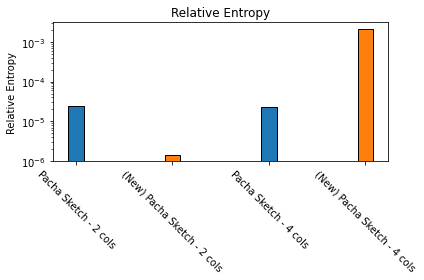

In [675]:
colors = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
methods = ['Pacha Sketch - 2 cols', '(New) Pacha Sketch - 2 cols', 'Pacha Sketch - 4 cols', '(New) Pacha Sketch - 4 cols']
rel_entropies = [relative_entropy_2_old, relative_entropy_2, relative_entropy_4_old, relative_entropy_4]

x = np.arange(len(rel_entropies))
width = 0.16

plt.figure(figsize=(6, 4))
plt.bar(x, rel_entropies, color=colors, width=width, edgecolor='black')
plt.xticks(x, methods, rotation=-45)
plt.ylabel("Relative Entropy")
plt.title("Relative Entropy")
plt.yscale('log')  
plt.tight_layout()
plt.show()

## Bank Marketing

In [5]:
cat_updates = 7
num_updates = 6

In [6]:
bank_df = pd.read_parquet("../data/clean/bank_marketing.parquet")

query_path = "../queries/bank_marketing_2_cols.json"
with open(query_path, 'rb') as f:
    bank_queries_2 = orjson.loads(f.read())

query_path = "../queries/bank_marketing_4_cols.json"
with open(query_path, 'rb') as f:
    bank_queries_4 = orjson.loads(f.read())
bank_ad_tree = ADTree.from_json("../sketches/ad_trees/bank_marketing.json")

In [ ]:
bank_p_sketch = PachaSketch.build_with_uniform_size(
    levels=6,
    num_dimensions=10,
    cat_col_map=[0,1,2,3,4,5],
    num_col_map=[6,7,8,9],
    bases=[4, 5, 2, 2],
    # bases=[5, 5, 5, 5],
    ad_tree=bank_ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(bank_df)),
    cat_index_parameters=BFParameters(n_values=len(bank_df)*cat_updates, p=bloom_p),
    num_index_parameters=BFParameters(n_values=len(bank_df)*num_updates, p=bloom_p),
    region_index_parameters= BFParameters(n_values=len(bank_df)*(cat_updates+num_updates), p=bloom_p))
bank_p_sketch.get_size()

15.502957344055176

In [99]:
bank_p_sketch.update_data_frame(bank_df)

Updating: 100%|██████████| 45211/45211 [06:47<00:00, 111.04it/s] 


In [110]:
def compute_number_of_updates(levels, n_cat, n_num):
    curr_cat_index = n_cat + 1
    curr_num_index = levels
    curr_region_index = curr_cat_index * curr_num_index
    curr_base_sketches = curr_region_index
    curr_total = curr_cat_index + curr_num_index + curr_region_index + curr_base_sketches

    print("Nr. of updates in current solution:")
    print(f"cat_index: {curr_cat_index}")
    print(f"num_index: {curr_num_index}")
    print(f"region_index: {curr_region_index}")
    print(f"base_sketches: {curr_base_sketches}")
    print(f"Total: {curr_total}\n")

    new1_cat_index = n_cat + 1
    new1_num_index = levels**n_num
    new1_region_index = new1_cat_index * new1_num_index
    new1_base_sketches = new1_region_index
    new1_total = new1_cat_index + new1_num_index + new1_region_index + new1_base_sketches

    print("Nr. of updates in new solution 1:")
    print(f"cat_index: {new1_cat_index}")
    print(f"num_index: {new1_num_index}")
    print(f"region_index: {new1_region_index}")
    print(f"base_sketches: {new1_base_sketches}")
    print(f"Total: {new1_total}")
    print(f"Ratio: {new1_total / curr_total}\n")

    new2_cat_index = n_cat + 1
    new2_num_index = 2**n_num * levels
    new2_region_index = new2_cat_index * new2_num_index
    new2_base_sketches = new2_region_index
    new2_total = new2_cat_index + new2_num_index + new2_region_index + new2_base_sketches

    print("Nr. of updates in new solution 2:")
    print(f"cat_index: {new2_cat_index}")
    print(f"num_index: {new2_num_index}")
    print(f"region_index: {new2_region_index}")
    print(f"base_sketches: {new2_base_sketches}")
    print(f"Total: {new2_total}")
    print(f"Ratio: {new2_total / curr_total}\n")

    new3_cat_index = n_cat + 1
    new3_num_index = (n_num + 1) * levels
    new3_region_index = new3_cat_index * new3_num_index
    new3_base_sketches = new3_region_index
    new3_total = new3_cat_index + new3_num_index + new3_region_index
    print("Nr. of updates in new solution 3:")
    print(f"cat_index: {new3_cat_index}")
    print(f"num_index: {new3_num_index}")
    print(f"region_index: {new3_region_index}")
    print(f"base_sketches: {new3_base_sketches}")
    print(f"Total: {new3_total}")
    print(f"Ratio: {new3_total / curr_total}\n")

    new4_cat_index = n_cat + 1
    new4_num_index = (2+n_num+(n_num*(n_num-1)/2)) * levels
    new4_region_index = new4_cat_index * new4_num_index 
    new4_base_sketches = new4_region_index
    new4_total = new4_cat_index + new4_num_index + new4_region_index + new4_base_sketches
    print("Nr. of updates in new solution 4:")
    print(f"cat_index: {new4_cat_index}")
    print(f"num_index: {new4_num_index}")   
    print(f"region_index: {new4_region_index}")
    print(f"base_sketches: {new4_base_sketches}")
    print(f"Total: {new4_total}")
    print(f"Ratio: {new4_total / curr_total}\n")

In [111]:
levels = 6
# Retail
n_cat = 3
n_num = 3

print("--------------------------------------------------------")
print("Retail Dataset")
compute_number_of_updates(levels, n_cat, n_num)

# Bank
n_cat = 6
n_num = 4

print("--------------------------------------------------------")
print("Bank Dataset")
compute_number_of_updates(levels, n_cat, n_num)

# Folktables
n_cat = 7
n_num = 3

print("--------------------------------------------------------")
print("Folktables Dataset")
compute_number_of_updates(levels, n_cat, n_num)



--------------------------------------------------------
Retail Dataset
Nr. of updates in current solution:
cat_index: 4
num_index: 6
region_index: 24
base_sketches: 24
Total: 58

Nr. of updates in new solution 1:
cat_index: 4
num_index: 216
region_index: 864
base_sketches: 864
Total: 1948
Ratio: 33.58620689655172

Nr. of updates in new solution 2:
cat_index: 4
num_index: 48
region_index: 192
base_sketches: 192
Total: 436
Ratio: 7.517241379310345

Nr. of updates in new solution 3:
cat_index: 4
num_index: 24
region_index: 96
base_sketches: 96
Total: 124
Ratio: 2.1379310344827585

Nr. of updates in new solution 4:
cat_index: 4
num_index: 48.0
region_index: 192.0
base_sketches: 192.0
Total: 436.0
Ratio: 7.517241379310345

--------------------------------------------------------
Bank Dataset
Nr. of updates in current solution:
cat_index: 7
num_index: 6
region_index: 42
base_sketches: 42
Total: 97

Nr. of updates in new solution 1:
cat_index: 7
num_index: 1296
region_index: 9072
base_sketch

In [ ]:
delta = 0.01
abs_error_eps = 1.0
bloom_p = 0.01

## Retail

In [ ]:
cat_updates = 4
num_updates = 6

In [ ]:
retail_df = pd.read_parquet("../data/clean/online_retail_no_outliers.parquet")

In [ ]:
query_path = "../queries/online_retail_2_cols.json"
with open(query_path, 'rb') as f:
    retail_queries_2 = orjson.loads(f.read())

query_path = "../queries/online_retail_4_cols.json"
with open(query_path, 'rb') as f:
    retail_queries_4 = orjson.loads(f.read())

retail_ad_tree = ADTree.from_json("../sketches/ad_trees/online_retail.json")


In [ ]:
retail_p_sketch = PachaSketch.build_with_uniform_size(
    levels=6,
    num_dimensions=6,
    cat_col_map=[0,1,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=retail_ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
    cat_index_parameters=BFParameters(n_values=len(retail_df)*cat_updates, p=bloom_p),
    num_index_parameters=BFParameters(n_values=len(retail_df)*num_updates, p=bloom_p),
    region_index_parameters= BFParameters(n_values=len(retail_df)*(cat_updates+num_updates), p=bloom_p))
retail_p_sketch.get_size()

179.22578525543213

In [ ]:
retail_p_sketch.update_data_frame(retail_df)

Updating:   0%|          | 0/536494 [00:00<?, ?it/s]/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/pacha_sketch.py:623: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cat_values = tuple(element[i] for i in self.cat_col_map)
/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/pacha_sketch.py:624: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_values = tuple(element[i] for i in self.num_col_map)
Updating: 100%|██████████| 536494/536494 [03:02<00:00, 2942.80it/s]


In [ ]:
retail_results_2 = evaluate_queries(retail_df, retail_queries_2["queries"], retail_p_sketch, path_to_file="../results/accuracy/retail_2_p_sketch.csv")

Computing true counts...


True Count: 100%|██████████| 200/200 [00:05<00:00, 39.52it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [08:19<00:00,  2.50s/it]


In [ ]:
retail_results_4 = evaluate_queries(retail_df, retail_queries_4["queries"], retail_p_sketch, path_to_file="../results/accuracy/retail_4_p_sketch.csv")

Computing true counts...


True Count: 100%|██████████| 200/200 [00:06<00:00, 29.57it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:26<00:00,  7.47it/s]


In [35]:
np.prod([len(cover) for cover in covers_down])

4224

In [11]:
bank_queries_2["queries"][0]

[['unknown'], '*', '*', '*', '*', '*', '*', [125, 803], '*', '*']

In [12]:
bank_p_sketch.get_subqueries(bank_queries_2["queries"][0])

KeyboardInterrupt: 

In [28]:
bank_results_2 = evaluate_queries(bank_df, bank_queries_2["queries"], bank_p_sketch, path_to_file="../results/accuracy/bank_2_p_sketch.csv")

Computing true counts...


True Count: 100%|██████████| 200/200 [00:00<00:00, 456.91it/s]


Computing estimates...


Estimates:   0%|          | 0/200 [00:57<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
bank_results_4 = evaluate_queries(bank_df, bank_queries_4["queries"], bank_p_sketch, path_to_file="../results/accuracy/bank_4_p_sketch.csv")